In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import numpy as np
from glob import glob
import tqdm

%matplotlib inline

In [2]:
import matplotlib as mpl

# Load the data.

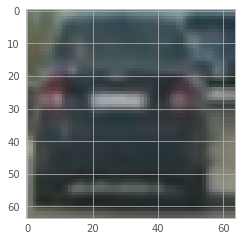

In [3]:
img = mpimage.imread('data/vehicles/vehicles/GTI_MiddleClose/image0000.png')
plt.imshow(img)

In [4]:
subKeys = {
    'vehicles': ['GTI_Far', 'GTI_Left', 'GTI_Right', 'GTI_MiddleClose'],
    'non-vehicles': ['GTI'],
}

In [5]:
paths = []
for mainKey in subKeys.keys():
    for subKey in subKeys[mainKey]:
        basePath = './data/%s/%s/%s/*.png' % (mainKey, mainKey, subKey)
        paths.extend([
            (
                int(path.split('/')[-1].replace('.png', '').replace('image', '')),
                mainKey,
                subKey,
                path,
            )
            for path in glob(basePath)
        ])

In [6]:
paths[0]

(285, 'vehicles', 'GTI_Far', './data/vehicles/vehicles/GTI_Far/image0285.png')

In [7]:
ids = [x[0] for x in paths]
Y = [
    0 if veh == 'non-vehicles' else (subKeys['vehicles'].index(gti)+1)
    for (i, veh, gti, path)
    in paths
]
images = [
    mpimage.imread(path)
    for (i, veh, gti, path) in tqdm.tqdm_notebook(paths, unit='path')
]

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

IDs are non-unique, so useless.

In [8]:
len(ids), len(set(ids))

(6726, 3901)

Images fit comfortably in memory, however.

In [9]:
d = images[0].dtype
print('%.3g MB' % (sum([x.size for x in images]) * d.alignment / 1024. / 1024.,))

315 MB


# Visualize a colorspace.

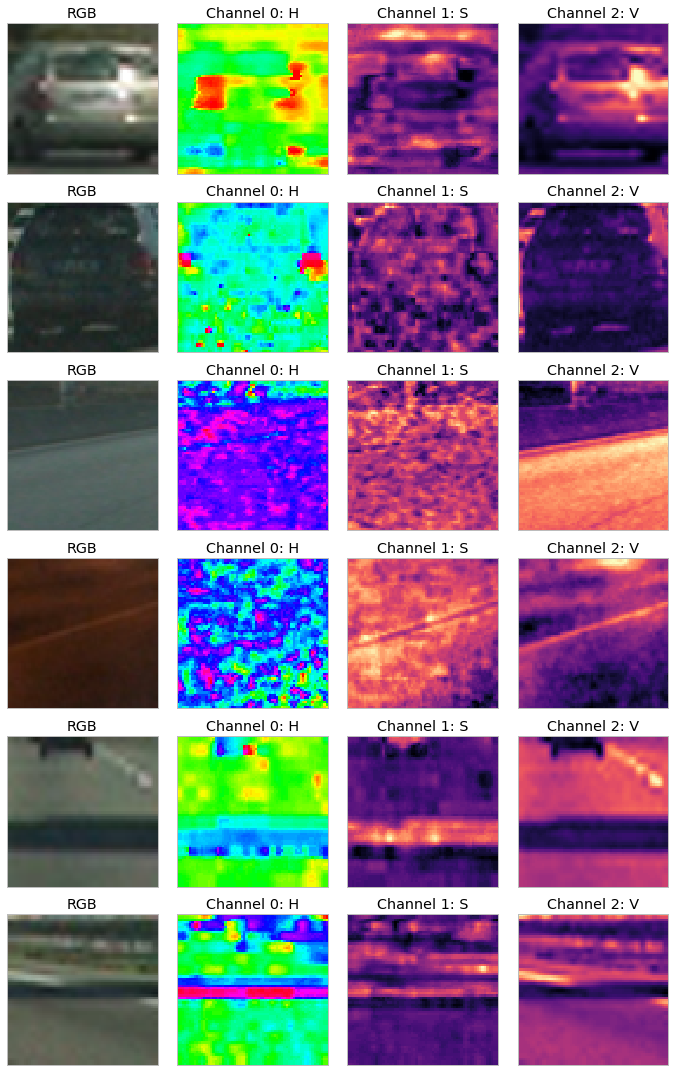

In [10]:
import cv2
def showCspace(img, cspace, axes=None):
    if axes is None:
        fig, axes = plt.subplots(ncols=4, figsize=(20, 6))
    if cspace != 'RGB':
        cvt = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2%s' % cspace))
    else:
        cvt = img
    for i, ax in enumerate(axes):
        if i == 0:
            ax.imshow(img)
            ax.set_title('RGB')
        else:
            if len(cspace) == 3:
                c = cspace[i-1]
            else:
                assert cspace == 'YCrCb'
                c = ['Y', 'Cr', 'Cb'][i-1]
                
            if c == 'H':
                cmap = 'hsv'
            else:
                cmap = 'magma'
            ax.imshow(cvt[:, :, i-1], cmap=cmap)
            
            ax.set_title('Channel %d: %s' % (i-1, c))
        ax.set_xticks([])
        ax.set_yticks([])
    return axes

npix = 6
fig, axes = plt.subplots(ncols=4, nrows=npix, figsize=(10, 10. / 4 * npix))
for i in range(npix):
    iimg = [0, 1000, 4000, 5000, 5500, 5600][i]
    showCspace(images[iimg], 'HSV', axes=axes[i]);
fig.tight_layout()

# Fit a detector.

In [11]:
# from importlib import reload

In [12]:
# import tqdm
# from collections import defaultdict
# from sklearn.externals.joblib import Parallel, delayed
# class Callback(object):
#     completed = defaultdict(int)
#     def __init__(self, index, parallel):
#         from IPython.core.debugger import set_trace; set_trace()
#         self.index = index
#         self.parallel = parallel
#         self.pbar = tqdm.tqdm_notebook()
        
#     def __call__(self, index):
#         CallBack.completed[self.parallel] += 1
#         print("done with {}".format(CallBack.completed[self.parallel]))
#         self.pbar.update()
#         if self.parallel._original_iterable:
#             self.parallel.dispatch_next()
            
# import  sklearn.externals.joblib.parallel
# sklearn.externals.joblib.parallel.CallBack = CallBack

In [13]:
# import sklearn.model_selection._search
# reload(sklearn.model_selection._search)

In [14]:
import vehicleDetection
import vehicleDetection.search_classify
import vehicleDetection.detector
import vehicleDetection.lesson_functions
# reload(vehicleDetection)
# reload(vehicleDetection.search_classify)
# reload(vehicleDetection.detector)
# reload(vehicleDetection.lesson_functions)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


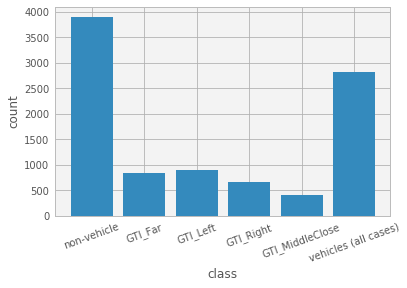

In [15]:
fig, ax = plt.subplots()
#classLabels = list(sorted(set(Y)))
classLabels = [0, 1, 2, 3, 4]
x = []
y = []
x.extend(classLabels)
y.extend([Y.count(label) for label in classLabels])
x.append(5)
y.append(np.array(Y).astype(bool).astype(int).sum())
ax.bar(x, y)
ax.set_xticks(range(6))
classLabelNames = ['non-vehicle']
classLabelNames.extend(subKeys['vehicles'])
classLabelNames.append('vehicles (all cases)')
ax.set_xticklabels(classLabelNames, rotation=20);
ax.set_ylabel('count')
ax.set_xlabel('class');

In [16]:
indices = np.arange(len(images))
np.random.shuffle(indices)
n = 2048
imageWindows = [images[i] for i in indices[:n]]
classes = [Y[i] for i in indices[:n]]

In [17]:
best_params_ = {'gamma': 6.5793322465756827e-05, 'kernel': 'rbf', 'C': 15.199110829529332}
best_params_ = {'kernel': 'linear', 'C': 12.0}

In [18]:
# %%time

# detector = vehicleDetection.detector.Detector()
# detector.fit(
#     imageWindows, 
#     classes,
# )
# best_params_ = detector.clf.best_params_

Show the hyperparameter search score results.

In [19]:
# scores = [sc.mean_validation_score for sc in detector.clf.grid_scores_]
# Cs = [sc.parameters['C'] for sc in detector.clf.grid_scores_]
# gammas = [sc.parameters['gamma'] for sc in detector.clf.grid_scores_]
# Cflat = list(sorted(set(Cs)))
# gammaflat = list(sorted(set(gammas)))
# grid = np.ones((len(Cflat), len(gammaflat))) * np.mean(scores)

# for score, C, gamma in zip(scores, Cs, gammas):
#     iC = Cflat.index(C)
#     ig = gammaflat.index(gamma)
#     grid[iC, ig] = score
        
# fig, ax = plt.subplots(figsize=(16,9))
# im = ax.imshow(grid, origin='lower', interpolation='spline16', cmap='hot')
# fig.colorbar(im, label='score')

# # sc = ax.scatter(np.log10(gammas), np.log10(Cs), c=scores)
# # fig.colorbar(sc, label='score')

# C = detector.clf.best_params_['C']
# gamma = detector.clf.best_params_['gamma']
# ax.scatter(gammaflat.index(gamma), Cflat.index(C), label='best', color='grey', s=256)

# ax.set_xticks(range(len(gammaflat)))
# ax.set_yticks(range(len(Cflat)))
# logformat = lambda n: '$10^{%.2g}$' % np.log10(n)
# lfm = lambda l: [logformat(n) for n in l]
# ax.set_xticklabels(lfm(gammaflat))
# ax.set_yticklabels(lfm(Cflat))

# ax.set_title('hyperparameter search')
# ax.set_xlabel('$\log_{10}(\gamma)$')
# ax.set_ylabel('$\log_{10}(C)$');
# ax.legend();

# fig.savefig('doc/hyperparameterSearch.png')

In [20]:
# feat = detector.featurize(imageWindows[0]).reshape((1, -1))
# rescaled = detector.scaler.transform(feat)
# fig, ax = plt.subplots()
# ax.plot(feat.ravel(), linewidth=1, color='black')
# ax.set_ylabel('features')
# # ax.set_yscale('log')

# ax2 = ax.twinx()
# ax2.plot(rescaled.ravel(), linewidth=1, color='red');
# ax2.set_ylabel('rescaled features', color='red')

In [21]:
# def predict(image):
#     feat = detector.featurize(image).reshape((1, -1))
#     rescaled = detector.scaler.transform(feat)
#     return np.copy(detector.clf.predict(rescaled))

In [22]:
# predictions = np.stack([predict(np.copy(image)) for image in imageWindows])

In [23]:
# fig, ax = plt.subplots()
# ax.hist([bool(y) for y in classes], color='black', label='data', alpha=.5);
# ax.hist(predictions, edgecolor='red', linewidth=4, label='predictions', alpha=.5, facecolor='none')
# ax.legend()
# ax.set_xticks([0, 1])
# ax.set_xticklabels(['non-vehicle', 'vehicle'])

What does the classifier think its accuracy is?

In [24]:
# detector.clf.best_estimator_.score(np.vstack([
#     detector.scaler.transform(detector.featurize(image).reshape((1, -1)))
#     for image in imageWindows
#     ]),
#     classes
# )

# Retrain the classifier on the full dataset with the best classifier parameters.

In [25]:
detector = vehicleDetection.detector.Detector(clfParameters=best_params_)

Got scalar parameter (C). Assuming no CV requested.


In [26]:
import sklearn.tree
CLF = sklearn.tree.DecisionTreeClassifier
best_params_ = dict(min_samples_split=2, min_samples_leaf=1, criterion='gini')
detector = vehicleDetection.detector.Detector(clfParameters=best_params_, CLF=CLF)

Got scalar parameter (min_samples_split). Assuming no CV requested.


In [27]:
%%time
detector.fit(
    images, 
    Y,
)nction(test_features)
                prediction = window.decisionFunc > 0

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of clf =  0.9242
CPU times: user 1min 4s, sys: 828 ms, total: 1min 5s
Wall time: 1min 5s


# Run the detector on a test image.

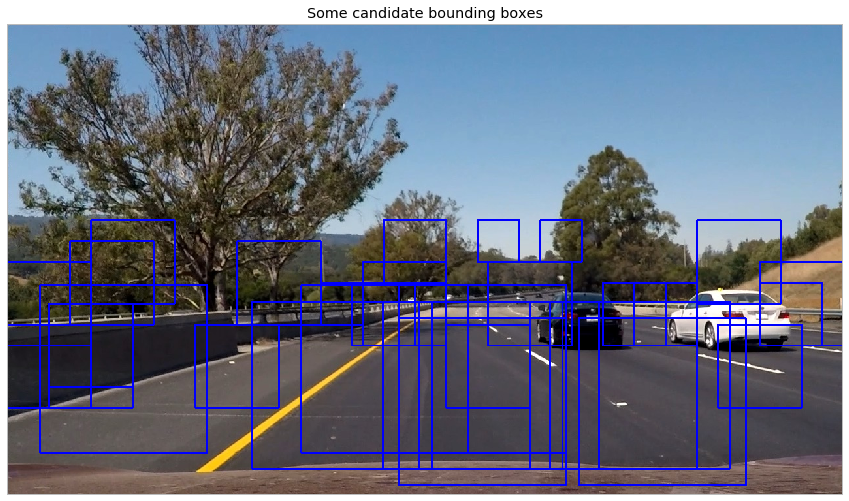

In [75]:
impath = 'test_images/test6.jpg'
img = mpimage.imread(impath)
windows = vehicleDetection.lesson_functions.slide_window(img)

windows = [w for w in detector.generateWindows(img)]
np.random.shuffle(windows)

nwin = 32
windows[:nwin]

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(
    vehicleDetection.lesson_functions.draw_boxes(
        img, windows[:nwin], thick=2,
    )
)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Some candidate bounding boxes')

Examine the test windows used.

In [76]:
testWindowImages = [
    cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    for window in windows
]

What is the distribution of predictions on this test image?

In [77]:
predictions = np.stack([
    detector.clf.predict(
        detector.scaler.transform(
            detector.featurize(im).reshape((1, -1))
        )
    )
    for im in testWindowImages
])

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


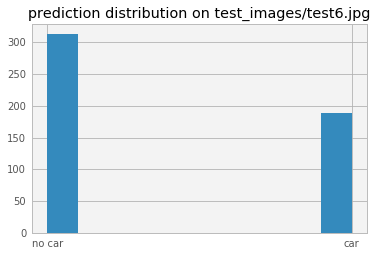

In [78]:
fig, ax = plt.subplots()
ax.hist(predictions)
ax.set_xticks([0, 1])
ax.set_xticklabels(['no car', 'car'])
ax.set_title('prediction distribution on %s' % impath);

Compare them to the training data.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


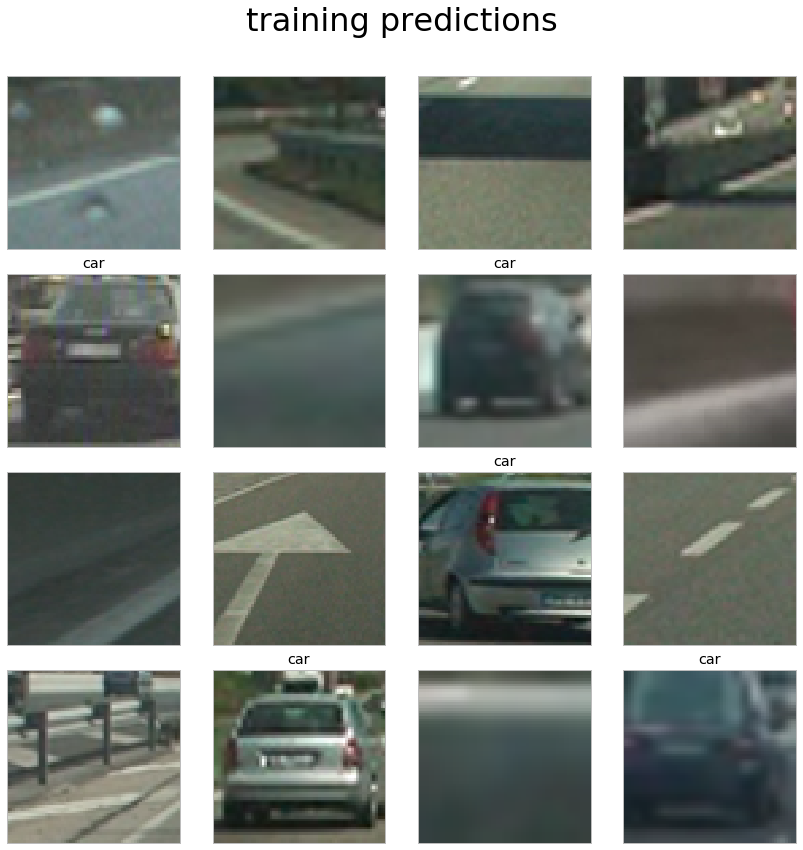

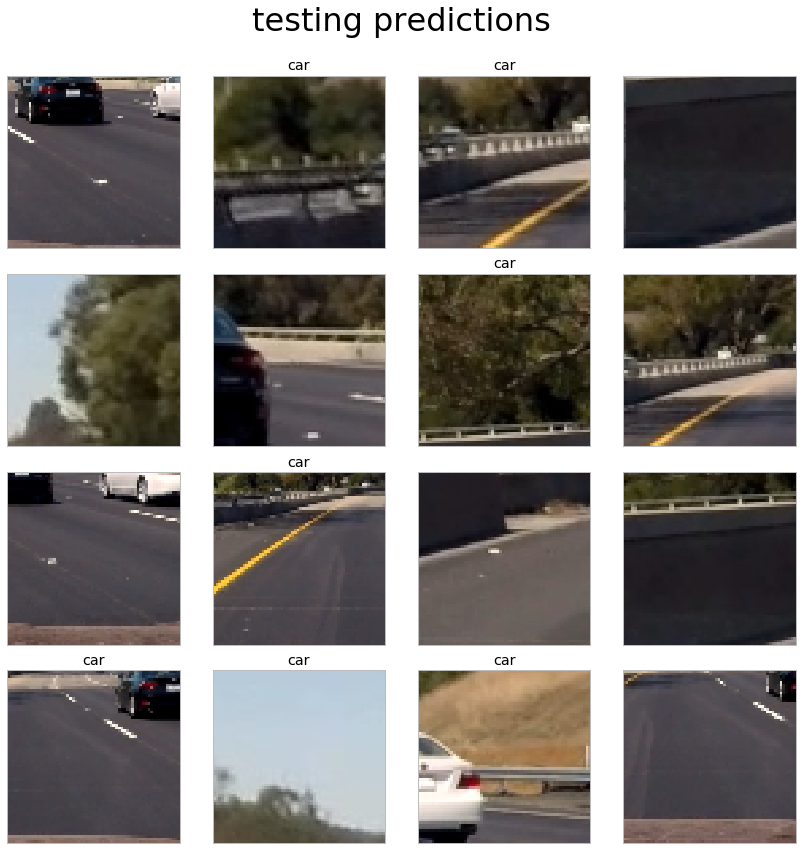

In [79]:
for imgs, suptitle in zip([imageWindows, testWindowImages], ['training predictions', 'testing predictions']):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    axes = axes.ravel()
    for im, ax in zip(imgs, axes):
        ax.imshow(im)
        features = detector.featurize(im).reshape((1, -1))
        test_features = detector.scaler.transform(features)
        pred = detector.clf.predict(test_features)
        if hasattr(detector.clf, 'decision_function'):
            decisionFunc = detector.clf.decision_function(test_features)
            dftext = ' ($f_d=%.2g$)' % decisionFunc
        else:
            dftext = ''
        ax.set_xticks([]); ax.set_yticks([])
        title = 'car%s' % dftext if pred else dftext
        ax.set_title(title)
    fig.tight_layout()
    fig.suptitle(suptitle, fontsize=32)
    fig.subplots_adjust(top=.9)
    fig.savefig('doc/%s.png' % suptitle)

In [80]:
windows = detector.rawDetect(img)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [81]:
len(windows), len(detector.generateWindows(img))

(188, 501)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


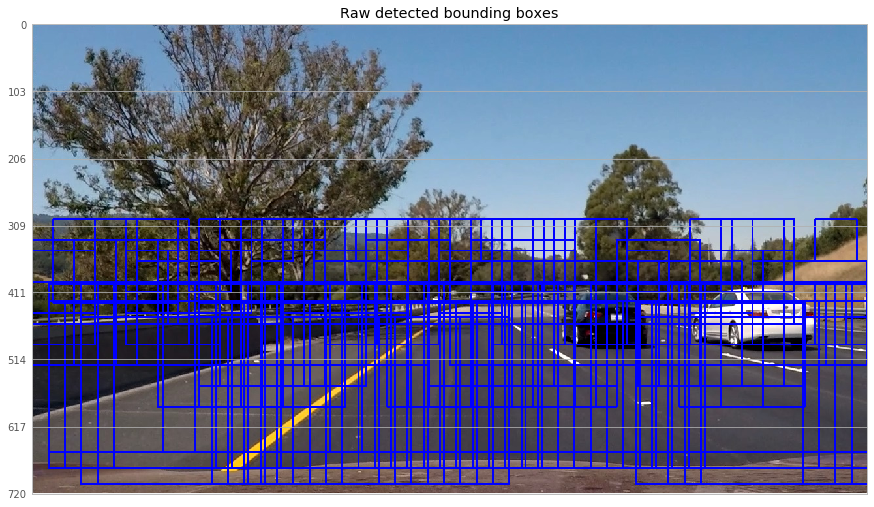

In [82]:
# from IPython.core.debugger import set_trace; set_trace()
ax = detector.drawDetect(img)
ax.set_title('Raw detected bounding boxes')
ax.set_yticks(np.round(np.linspace(0, 720, 8)))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


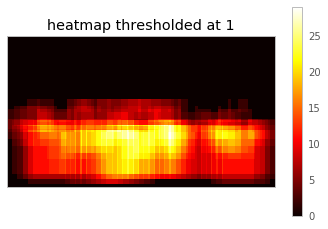

In [83]:
heatmap = detector.heat(img.shape, detector.rawDetect(img))
thr = 1
heatmap[heatmap <= thr] = 0
fig, ax = plt.subplots()
im = ax.imshow(heatmap[:, :, 0], cmap=mpl.cm.hot)
fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('heatmap thresholded at %s' % thr)

In [84]:
set(heatmap.ravel())

{0.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0}

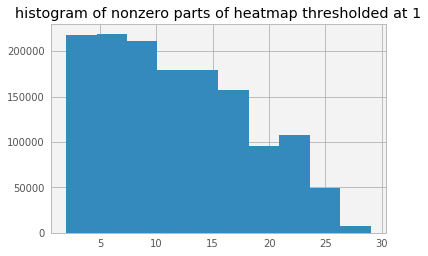

In [85]:
fig, ax = plt.subplots()
nz = heatmap[heatmap>0]
ax.hist(nz.ravel());
ax.set_title('histogram of nonzero parts of heatmap thresholded at %d' % thr);

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Found 1 labels.


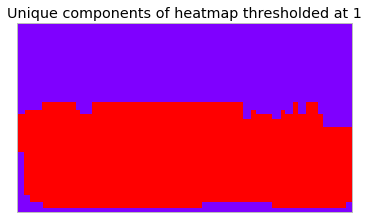

In [86]:
labels = detector.detect(img, threshold=thr)[0][:, :, 0]
fig, ax = plt.subplots()
ax.imshow(labels, cmap=mpl.cm.rainbow)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Unique components of heatmap thresholded at %d' % thr)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Found 1 labels.


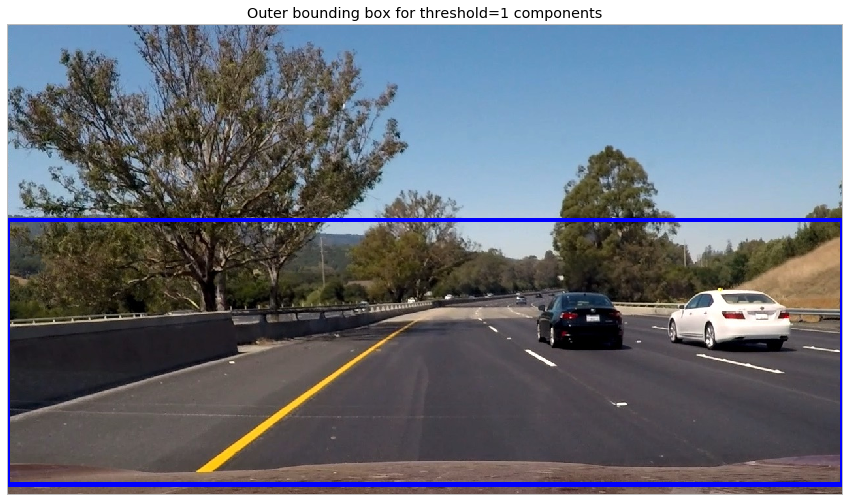

In [87]:
# from IPython.core.debugger import set_trace; set_trace()
ax = detector.drawHeat(img, threshold=thr)
ax.set_title('Outer bounding box for threshold=%d components' % thr)